# Predicting Evergreeness of Content with Decision Trees and Random Forests

In [ ]:
## DATA DICTIONARY

In [1]:
import pandas as pd
import json
import seaborn as sns
%matplotlib inline


data = pd.read_csv("../dataset/stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...


## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

In [2]:
data[['url', 'label']].head()

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0


### Exercises to Get Started

> ### Exercise: 1. In a group: Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- I.E. If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- I.E. If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

### Split up and develop 1-3 of the those features independently.

count    7395.000000
mean        0.275709
std         1.919320
min        -1.000000
25%         0.025900
50%         0.083051
75%         0.236700
max       113.333333
Name: image_ratio, dtype: float64
0    0
1    0
2    0
3    0
4    0
Name: high_image_page, dtype: int64


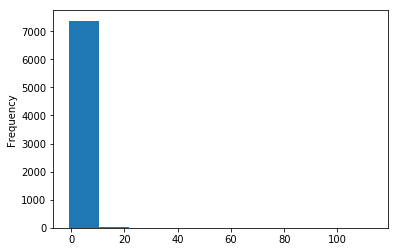

In [12]:
#first feature to capture: image content
print(data.image_ratio.describe())
data.image_ratio.plot(kind='hist')
data['high_image_page'] = data['image_ratio'].map(lambda x: x>.2367)

print((data['high_image_page']*1).head())

#second feature to capture


#third feature to capture


> ### Exercise: 3. Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

In [16]:
print(pd.crosstab(data['is_news'],data['label']))

#finding the odds ratio
odds_evergreen_ifnews = 2353/2199.0
print(odds_evergreen_ifnews)

odds_evergreen_ifnotnews = 1443/1400.0
print(odds_evergreen_ifnotnews)


label       0     1
is_news            
1        2199  2353
?        1400  1443
1.070031832651205
1.0307142857142857


> ### Exercise: 4. Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

['business' 'recreation' 'health' 'sports' '?' 'arts_entertainment'
 'science_technology' 'gaming' 'culture_politics' 'computer_internet'
 'law_crime' 'religion' 'weather' 'unknown']


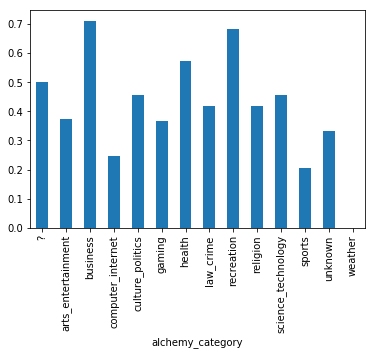

In [27]:
print(data.alchemy_category.unique())
data.groupby('alchemy_category').label.mean().plot(kind='bar')

> ### Exercise: 5. How many articles are there per category?

In [28]:
print(data.alchemy_category.value_counts())

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64


> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evegreen websites higher or lower on pages that have recipe in the the title?

In [41]:
def function_recipe(x):
    if x is None:
        return False
    if('recipe' in x.lower()):
        return True
    else:
        return False
    
#test
#a = 'Mom cooks a Recipe'
#function_recipe(a)

data['recipe'] = data.title.map(function_recipe)
print(data.recipe.head())

0    False
1    False
2    False
3    False
4    False
Name: recipe, dtype: bool


In [44]:
#another way to do the above
#def function_recipe(x):
#    if any('recipe' in s for s in x):
#        return True
#    else:
#        return False

#function_recipe(data['recipe'])
    

TypeError: argument of type 'numpy.bool_' is not iterable

###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

In [55]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
model.fit(X, y)

# Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model,
                              out_file = dotfile,
                              feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")
    
build_tree_image(model)

## Decision Trees in scikit-learn

 ### Exercise: Evaluate the decision tree using cross-validation; use AUC as the evaluation metric.

In [68]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate

scores = cross_val_score(model, X, y, scoring='roc_auc').mean()
print(scores)

0.62314777634


###  Adjusting Decision Trees to Avoid Overfitting

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [77]:
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
build_tree_image(model)

 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [109]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators = 100, n_jobs=-1)
    
model.fit(X, y)

#n_jobs=-1 sets all the cores of your computer to run the model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [110]:
cross_val_score(model,X,y).mean()

0.60446243062459504

### Demo: Extracting importance of features

In [111]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
2,recipe,0.663506
0,image_ratio,0.191542
1,html_ratio,0.144952


 ### Exercise: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [ ]:
# ... #

##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
  - 
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


count    7395.000000
mean        0.275709
std         1.919320
min        -1.000000
25%         0.025900
50%         0.083051
75%         0.236700
max       113.333333
Name: image_ratio, dtype: float64
0    1
1    1
2    1
3    1
4    1
Name: compress_ratio, dtype: int64


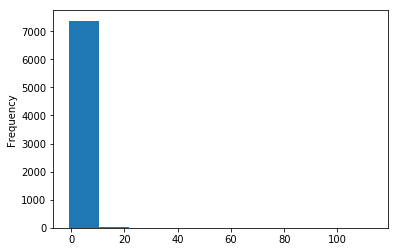

In [113]:
#first feature to capture: possible compressed images?
print(data.image_ratio.describe())
data.image_ratio.plot(kind='hist')
data['compress_ratio'] = data['compression_ratio'].map(lambda x: x>.0259)

print((data['compress_ratio']*1).head())

In [139]:
#second feature to capture: front page news
data['front_page_news'] = data['news_front_page'].map({'1':1,'?':0,'0':0})

In [141]:
#third feature to capture: is_News
data['is_news'] = data['is_news'].map({'1':1,'?':0})

In [147]:
#fourth feature
def function_sports(x):
    if x is None:
        return False
    if('sports' in x.lower()):
        return True
    else:
        return False

data['sports'] = data.title.map(function_sports)
print(data.sports.head())

def function_weather(x):
    if x is None:
        return False
    if('weather' in x.lower()):
        return True
    else:
        return False

data['weather'] = data.title.map(function_weather)
print(data.weather.head())

0    False
1    False
2    False
3    False
4    False
Name: sports, dtype: bool
0    False
1    False
2    False
3    False
4    False
Name: weather, dtype: bool


In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate

X = data[['weather','sports','image_ratio', 'html_ratio', 'recipe', 'label', 'compress_ratio','front_page_news','is_news']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)

model = RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators = 100, n_jobs=-1)
model.fit(X,y)
cross_val_score(model,X,y, scoring='roc_auc').mean()

0.67300139371588674